# Insurance Charges Prediction
Download the data from: https://www.kaggle.com/teertha/ushealthinsurancedataset (insurance.csv)  

Although the dataset is small (1338 samples), regression should give a "good" prediction for the insurance charge.

## Prepare the data
Load the data.  
&middot; encoding 'sex','smoker' and 'region'  
&middot; reordering the columns to be easier to read and cut for later 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv("csv_data/insurance.csv")

#binary category encoding 
ordinal_encoder = OrdinalEncoder()
data[['sex','smoker']] = ordinal_encoder.fit_transform(data[['sex','smoker']])

#category encoding using one-hot encoder
region_encoder = OneHotEncoder()
region_data = np.array(region_encoder.fit_transform(data[['region']]).toarray()).T
for col,i in zip(region_data,range(len(region_data))):
    data['region'+str(i)] = col
data = data.drop(['region'],axis=1)

#new column order
cols = data.columns.tolist()
cols = cols[:5] + cols[6:] + cols[5:6]
data = data[cols]

data.describe()

,age,sex,bmi,children,smoker,region0,region1,region2,region3,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,0.242152,0.242900,0.272048,0.242900,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,0.428546,0.428995,0.445181,0.428995,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,63770.428010


## Analysis
Explore the distribution.  
&middot; age is almost uniformly distributed (exept people of age below 20 who are overrepresented)  
&middot; bmi should be close to normal distribution  
&middot; charges look exponential (not enough data for highly charged)

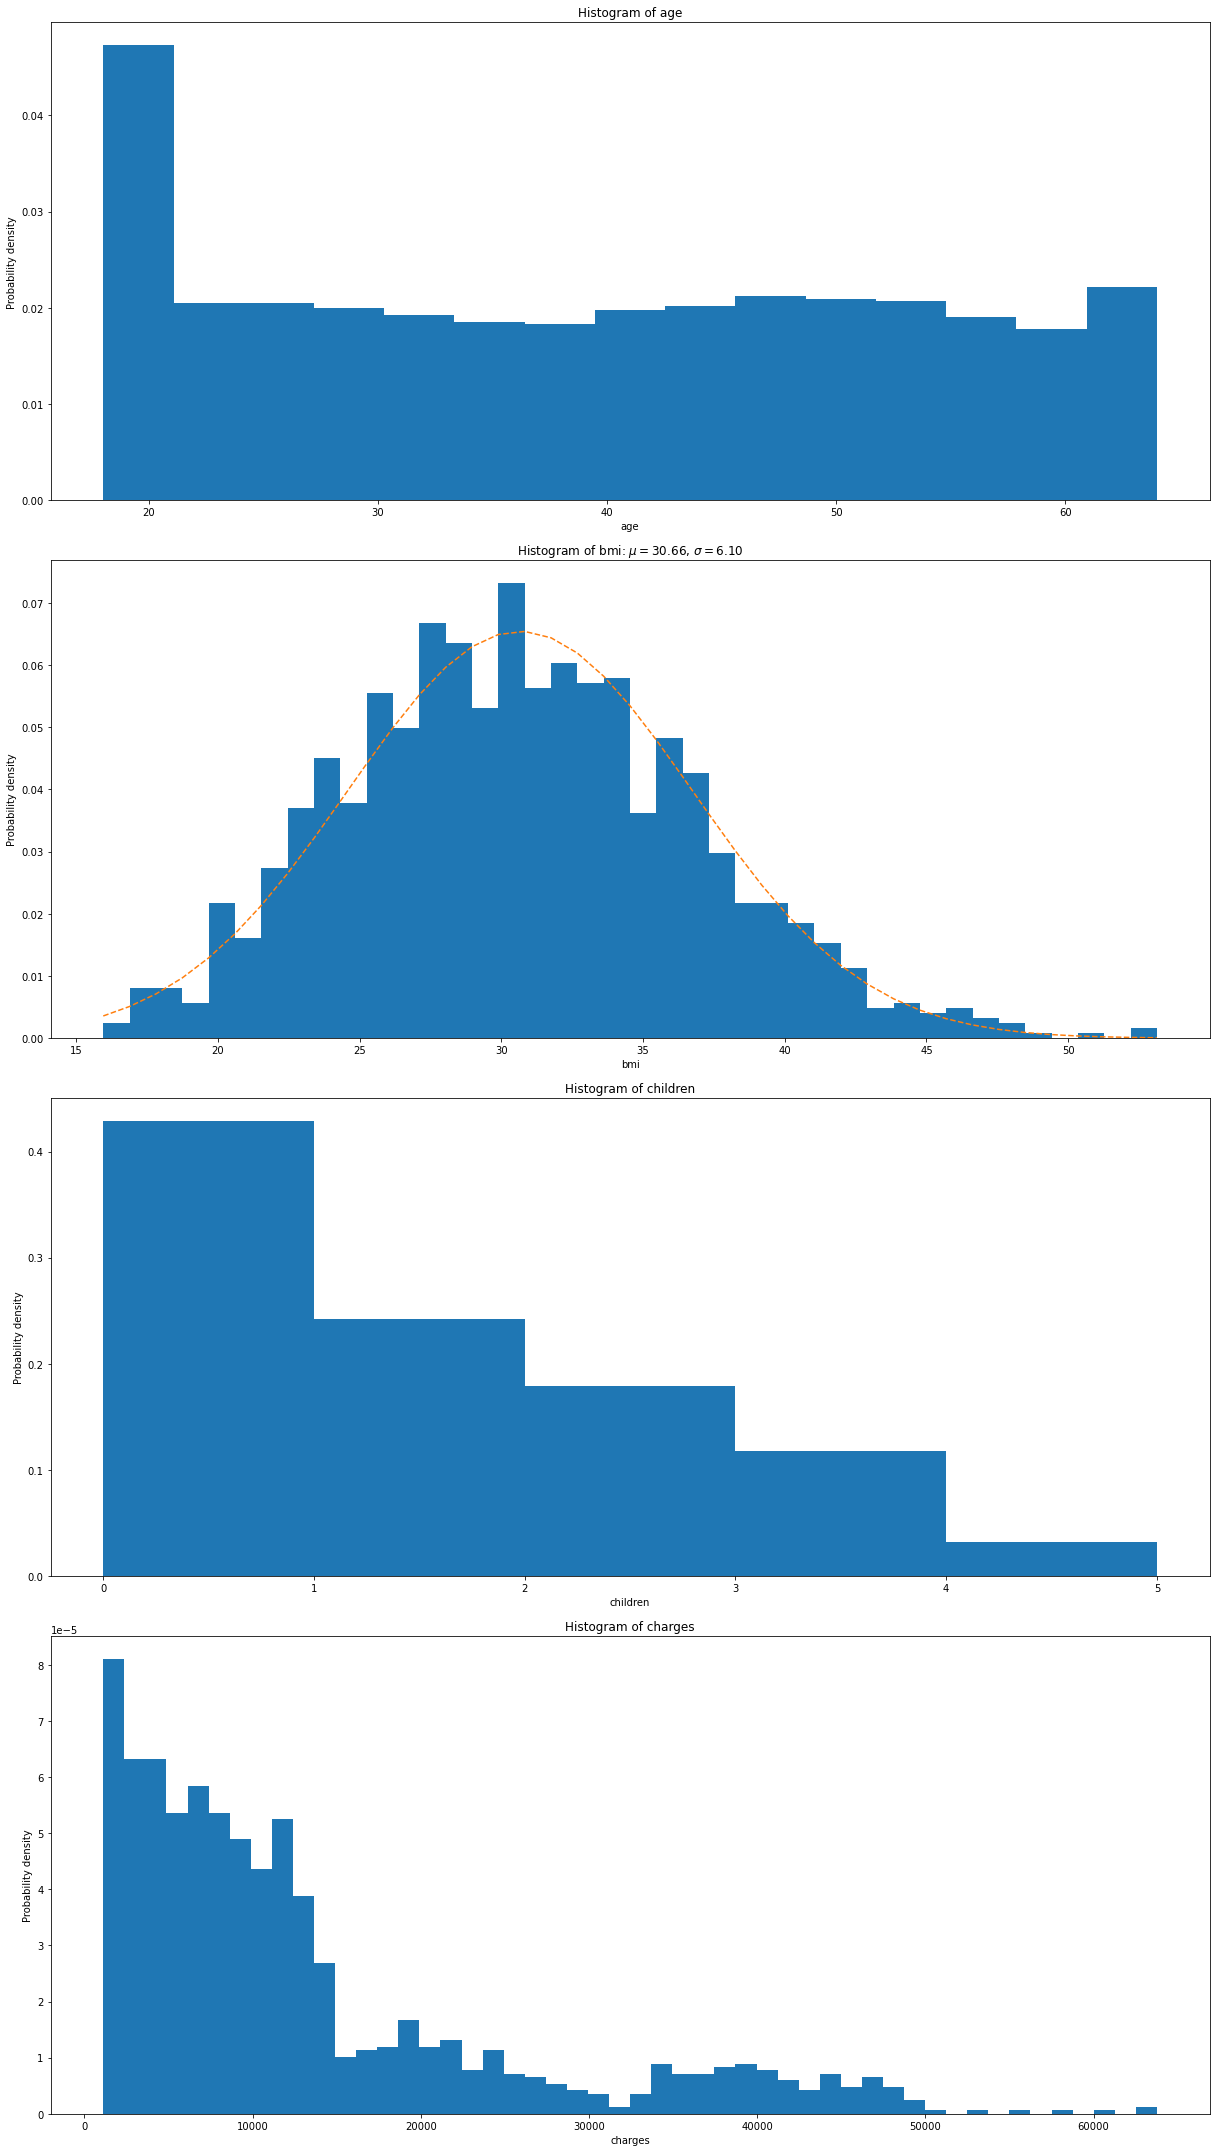

In [2]:
import matplotlib.pyplot as plt

def histograms(data):
    
    def normalDistLine(mean,std,bins):
        return ((1/(np.sqrt(2*np.pi)*std)) * np.exp(-0.5 * ((bins-mean)/std)**2))
    
    dist = [('age',15,data['age'].mean(),data['age'].std()),
            ('bmi',40,data['bmi'].mean(),data['bmi'].std()),
            ('children',5,data['children'].mean(),data['children'].std()),
            ('charges',50,data['charges'].mean(),data['charges'].std())]  

    fig, ax = plt.subplots(4,1, figsize=(17,30))

    for i in range(len(dist)):
        n, bins, patches = ax[i].hist(data[dist[i][0]], dist[i][1], density=True)
        ax[i].set_xlabel(dist[i][0])
        ax[i].set_ylabel('Probability density')
        ax[i].set_title(r'Histogram of {}'.format(dist[i][0]))
        if dist[i][0] == 'bmi':
            ax[i].plot(bins,normalDistLine(dist[i][2],dist[i][3],bins), '--')
            ax[i].set_title(r'Histogram of {}: $\mu={:.2f}$, $\sigma={:.2f}$'.format(dist[i][0],dist[i][2],dist[i][3]))

    fig.tight_layout()
    plt.show()
    
histograms(data)

Looking at the correlation matrix should help to understand the data a little better.

In [3]:
corr_matrix = data.corr()
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
region2     0.073982
children    0.067998
sex         0.057292
region0     0.006349
region1    -0.039905
region3    -0.043210
Name: charges, dtype: float64

## Split The Data
We should split the data before we imply augmentation.

In [4]:
#splitting into training and testing sets
train,test = train_test_split(data, test_size=0.2, random_state=42)
print(train.shape,test.shape)

(1070, 10) (268, 10)


A look on the testing set.  
Should look similar to the original dataset.

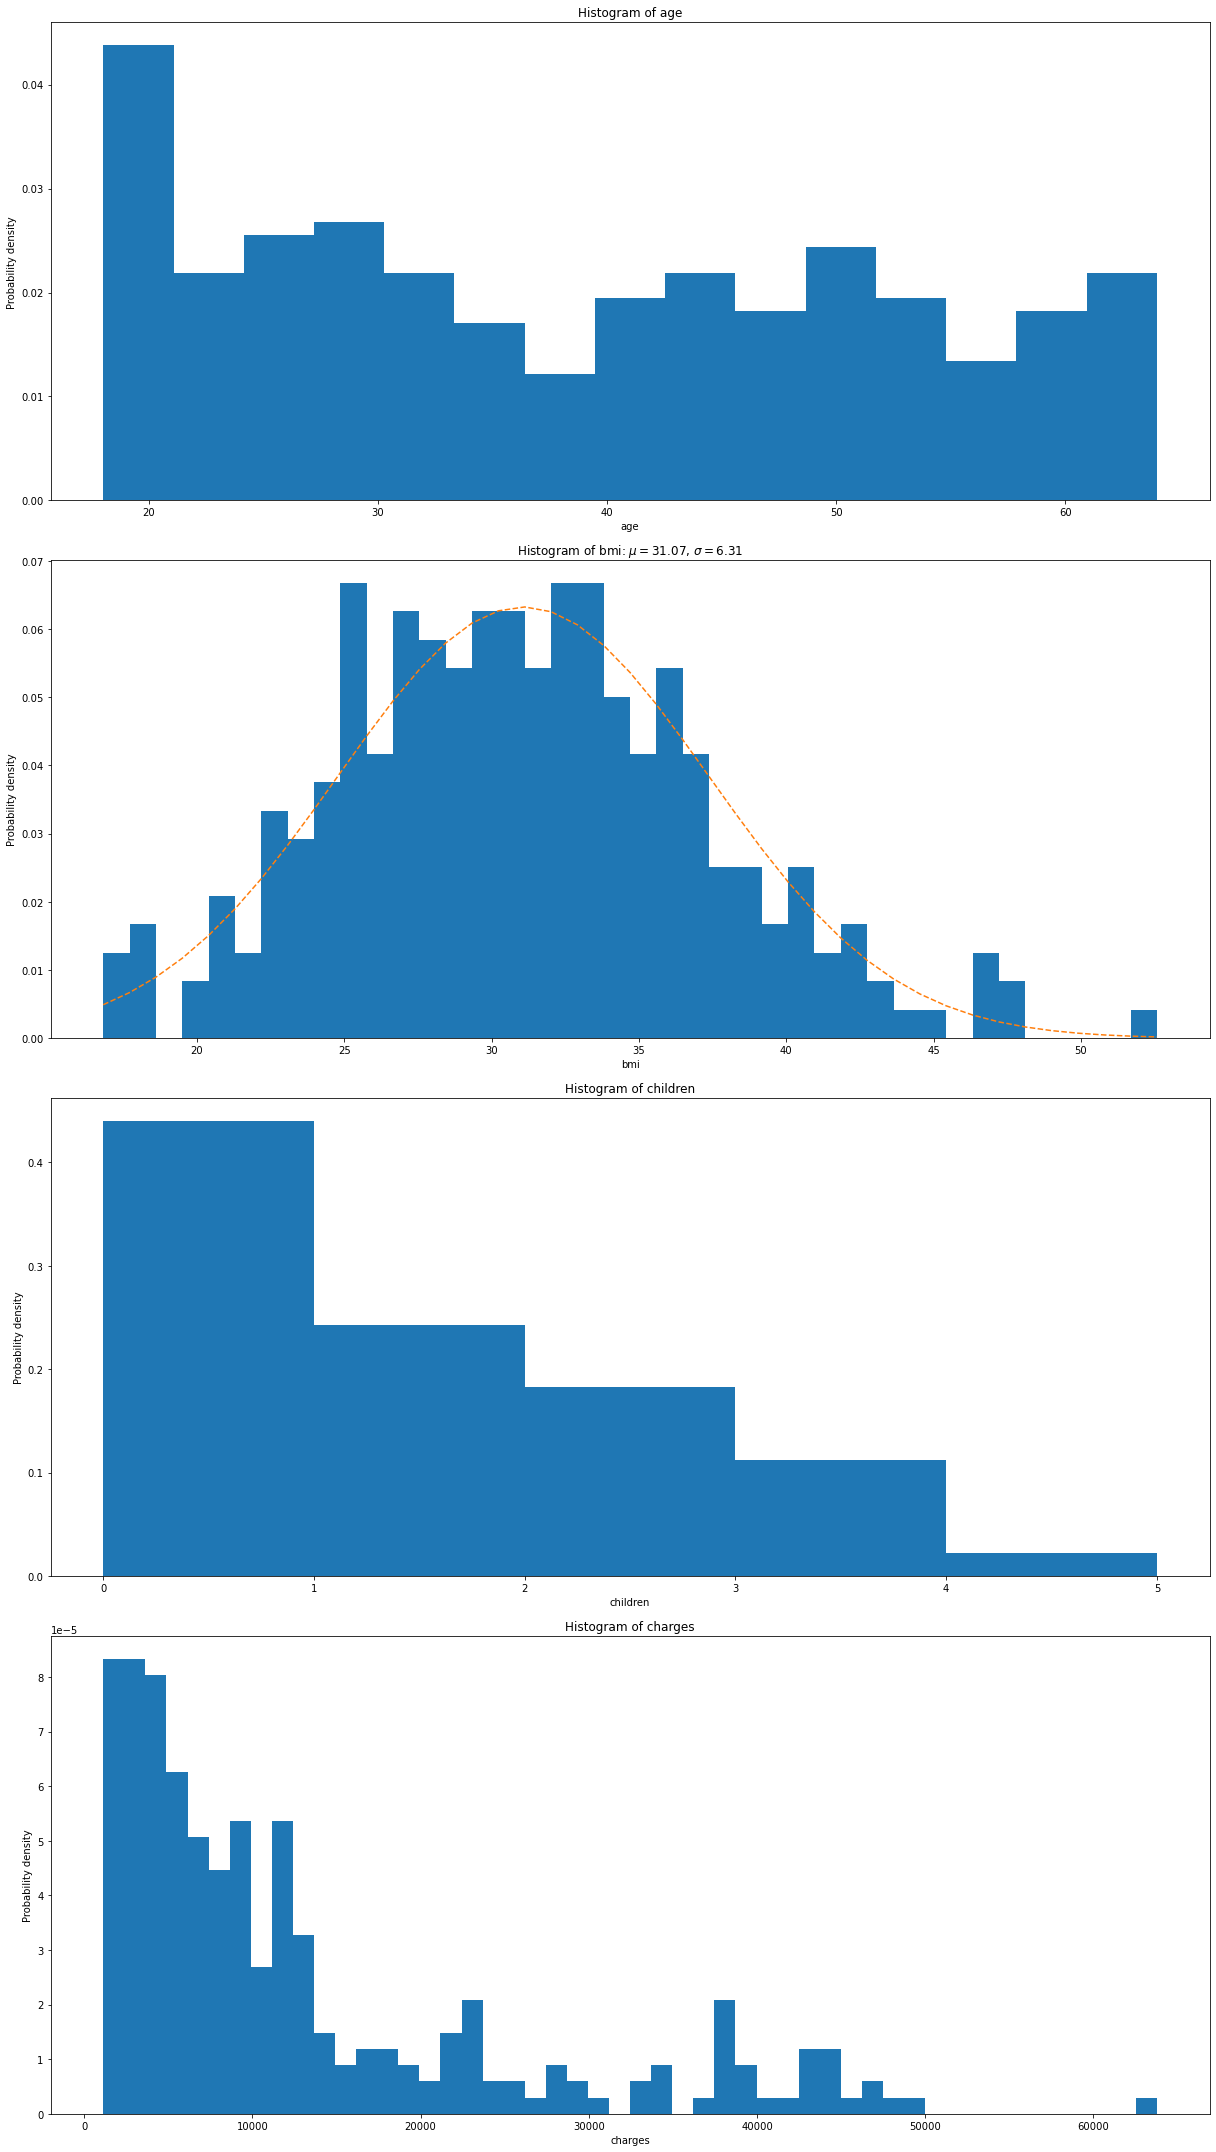

In [5]:
histograms(test)

## Data Augmentation
There is a strong correlation between 'charges' and 'smoker', and the mean of 'smoker' is 0.204783.    
We should add more data about smokers by finding "similar" people by most metrics that differ in there smoking habbit.  
&middot; the epsilons will help to regularize the data

In [6]:
epsilon_age = 3
epsilon_bmi = 2
epsilon_children = 1

aug_samples = []
for i in range(len(train)):
    data_sample = train.iloc[i].copy()
    if data_sample['smoker'] == True:
        continue
    new_data = train.loc[(np.abs(train['age'] - data_sample['age']) <= epsilon_age) &
        (np.abs(train['bmi'] - data_sample['bmi']) <= epsilon_bmi) &
        (np.abs(train['children'] - data_sample['children']) <= epsilon_children) &
        (train['region0'] == data_sample['region0']) &
        (train['region1'] == data_sample['region1']) &
        (train['region2'] == data_sample['region2']) &
        (train['region3'] == data_sample['region3']) &
        (train['smoker'] != data_sample['smoker'])]
    if new_data.empty == False:
        data_sample[['smoker','charges']] = [1.,new_data['charges'].mean()]
        aug_samples.append(data_sample)
        
train = train.append(aug_samples)
train.describe()

,age,sex,bmi,children,smoker,region0,region1,region2,region3,charges
count,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000
mean,39.243208,0.510349,30.563583,1.043984,0.450194,0.249030,0.240621,0.271022,0.239327,19189.767910
std,14.125296,0.500055,5.728225,1.162802,0.497674,0.432591,0.427599,0.444631,0.426811,14600.268822
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1121.873900
25%,26.000000,0.000000,26.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6952.059125
50%,40.000000,1.000000,30.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14450.844775
75%,51.000000,1.000000,34.372500,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,30357.252112
max,64.000000,1.000000,53.130000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,62592.873090


A look on the new training data.
Charges histogram should look a bit better.

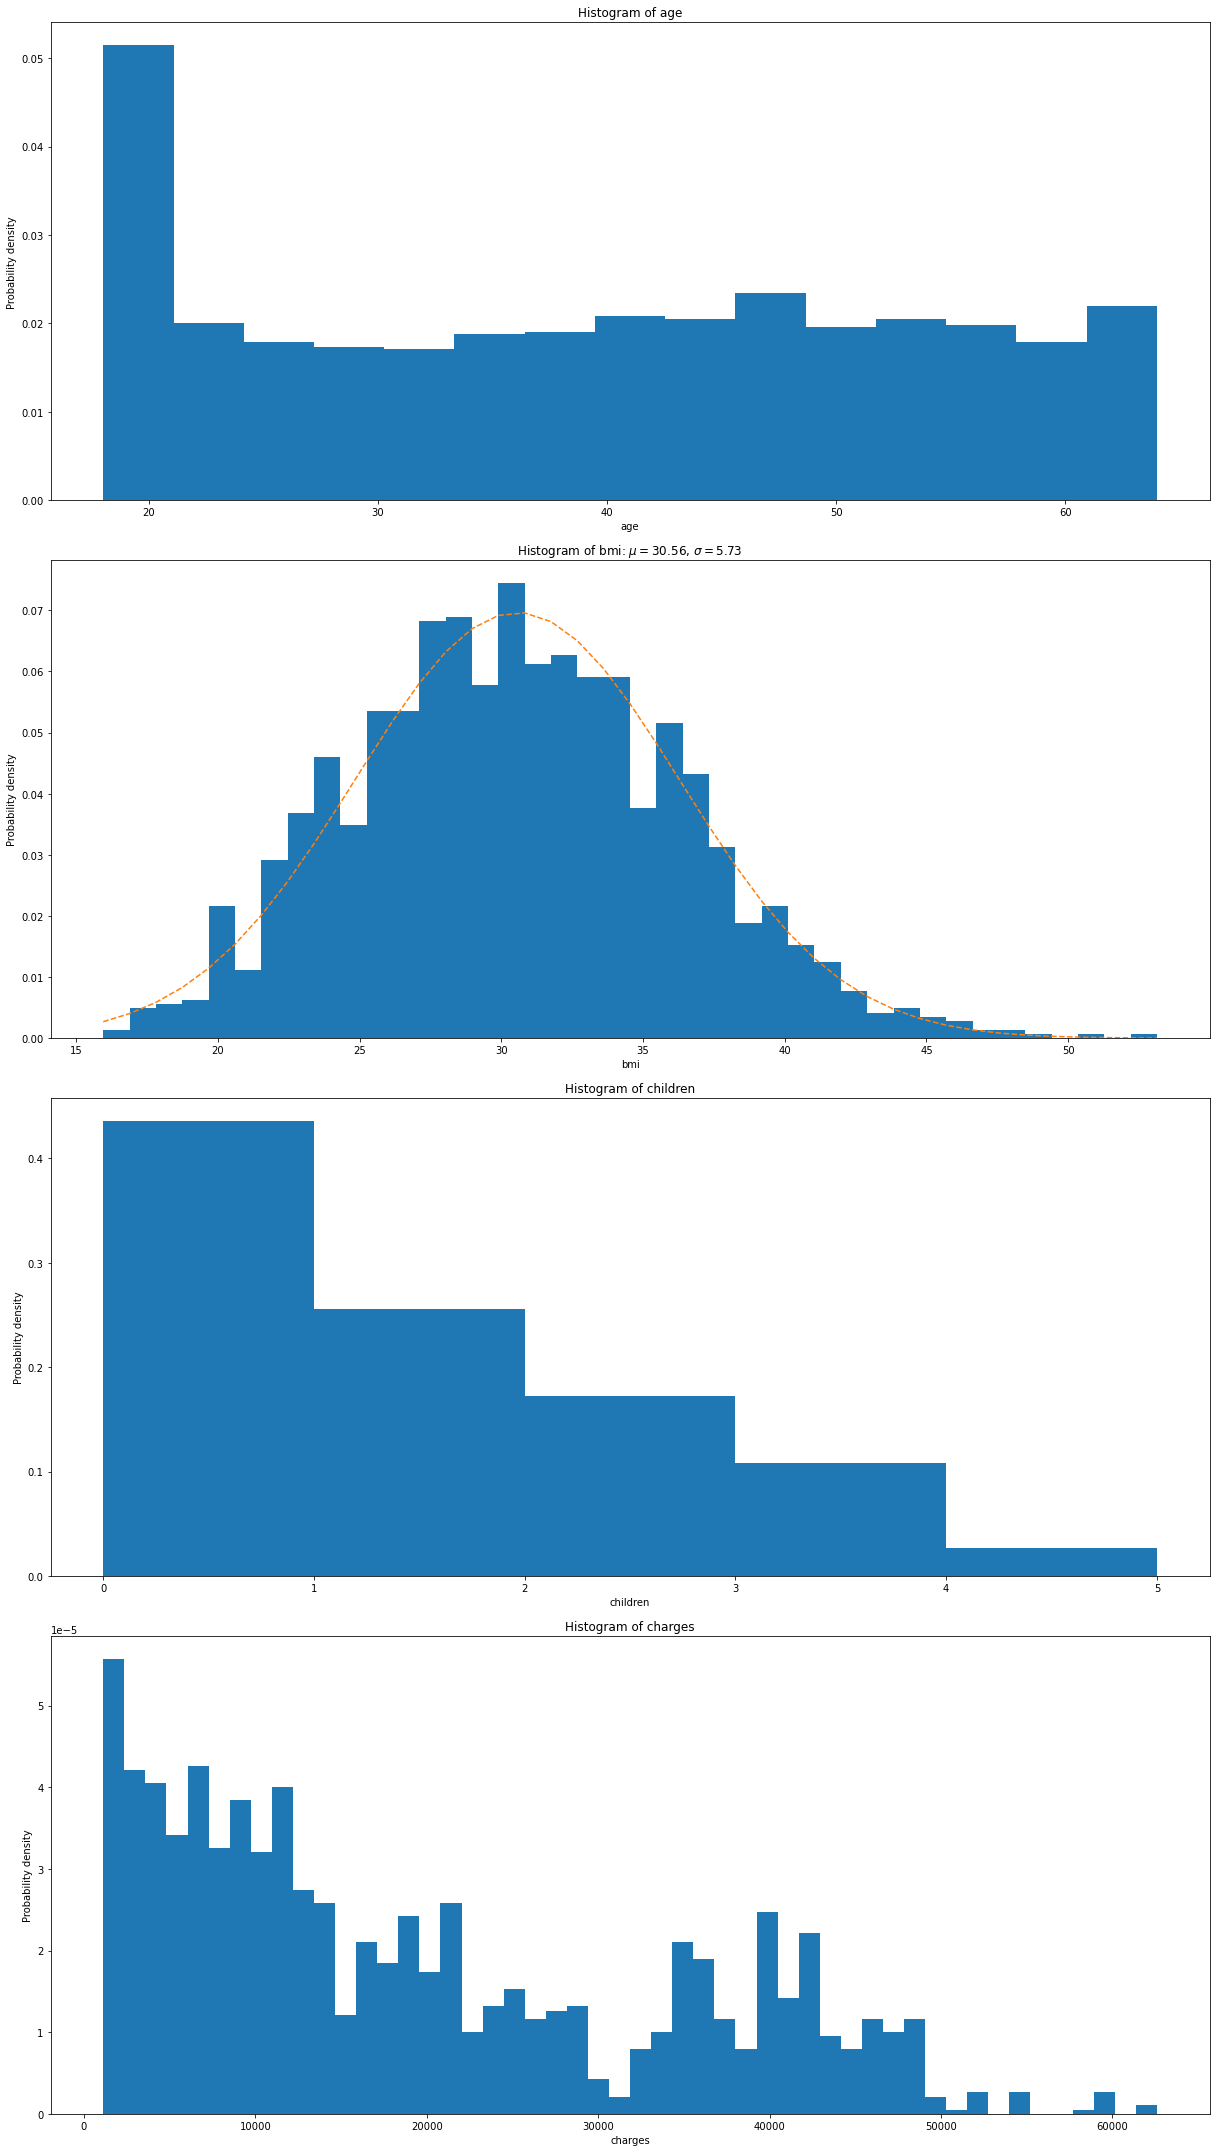

In [7]:
histograms(train)

## Normalize And Prepare

In [8]:
pd.options.mode.chained_assignment = None
#normalization
def normalize(data):
    data.loc[:,'age'] = data['age'] * 1.
    data.loc[:,'children'] = data['children'] * 1.
    data.loc[:,'age'] = data['age'] / data['age'].max()
    data.loc[:,'bmi'] = data['bmi'] / data['bmi'].max()
    data.loc[:,'children'] = data['children'] / data['children'].max()

normalize(train)
normalize(test)

Ytrain = train.iloc[:,-1].ravel()
Xtrain = train.iloc[:,:-1]
Ytest = test.iloc[:,-1].ravel()
Xtest = test.iloc[:,:-1]

# Models

## Ridge Regression

In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor

param_grid = [
 {'poly_features__degree': [2,3,4],
  'poly_features__include_bias': [True,False],
  'ridge_reg__alpha': [0.1,0.2,0.5]
 }]

ridge_reg = Pipeline([
 ("poly_features", PolynomialFeatures()),
    ("ridge_reg", Ridge())])

grid_search = GridSearchCV(ridge_reg, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(Xtrain, Ytrain)
grid_search.best_params_

{'poly_features__degree': 3,
 'poly_features__include_bias': False,
 'ridge_reg__alpha': 0.2}

In [10]:
ridge_reg = Pipeline([
 ("poly_features", PolynomialFeatures(degree=3,include_bias=False)),
    ("ridge_reg", Ridge(alpha=0.2))])

bag_ridge_reg = BaggingRegressor(ridge_reg, n_estimators=100, max_samples=0.2,  bootstrap=True, n_jobs=-1)

score_train = np.sqrt(-1*cross_val_score(bag_ridge_reg,Xtrain,Ytrain,scoring="neg_mean_squared_error",cv=5))
bag_ridge_reg.fit(Xtrain,Ytrain)
ridge_train = bag_ridge_reg.predict(Xtrain) 
ridge_test = bag_ridge_reg.predict(Xtest)

rmse = np.sqrt(MSE(Ytest, ridge_test)) 
print("Ridge Model:")
print("Cross validation Score:",score_train.mean(),"+/-",score_train.std())
print("Test sample Score: %f" %(rmse),"\n")

Ridge Model:
Cross validation Score: 5077.564195414184 +/- 403.6345354189412
Test sample Score: 4636.329356 



## Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

param_grid = [
 {'bootstrap': [True],'n_jobs': [-1],
  'max_samples': [0.3,0.5], 
  'n_estimators': [50, 75, 100],
  'max_features': range(3,8)}]

rf_reg = RandomForestRegressor()
grid_search = GridSearchCV(rf_reg, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(Xtrain, Ytrain)
grid_search.best_params_

{'bootstrap': True,
 'max_features': 6,
 'max_samples': 0.3,
 'n_estimators': 100,
 'n_jobs': -1}

In [12]:
rf_reg = RandomForestRegressor(bootstrap=True,max_features=5,max_samples=0.3,n_estimators=75,n_jobs=-1)
score_train = np.sqrt(-1*cross_val_score(rf_reg,Xtrain,Ytrain,scoring="neg_mean_squared_error",cv=5))

rf_reg.fit(Xtrain,Ytrain)
rf_train = rf_reg.predict(Xtrain)
rf_test = rf_reg.predict(Xtest)

rmse = np.sqrt(MSE(Ytest, rf_test))
print("Random Forest Model:")
print("Cross validation Score:",score_train.mean(),"+/-",score_train.std())
print("Test sample Score: %f" %(rmse),"\n")

Random Forest Model:
Cross validation Score: 4460.93921659632 +/- 315.76529220547957
Test sample Score: 4335.247877 



## Neural Network

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dnn = Sequential([
    Flatten(input_shape=[9]),
    Dense(9, activation="relu"),
    Dense(5, activation="relu"),
    Dense(1, activation="relu")
])

callback = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
dnn.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.3),metrics="mean_squared_error")
dnn.fit(Xtrain, np.array(Ytrain), epochs=120, validation_data=(Xtest, np.array(Ytest)), callbacks=[callback])
dnn_train= dnn.predict(Xtrain).ravel()
dnn_test = dnn.predict(Xtest).ravel()

print("\nDNN Model:")
np.sqrt(dnn.evaluate(Xtest, np.array(Ytest))[0])

Epoch 1/120
49/49 [==============================] - 0s 4ms/step - loss: 325327968.0000 - mean_squared_error: 325327968.0000 - val_loss: 99472032.0000 - val_mean_squared_error: 99472032.0000
Epoch 2/120
49/49 [==============================] - 0s 952us/step - loss: 93691552.0000 - mean_squared_error: 93691552.0000 - val_loss: 49757656.0000 - val_mean_squared_error: 49757656.0000
Epoch 3/120
49/49 [==============================] - 0s 824us/step - loss: 61517476.0000 - mean_squared_error: 61517476.0000 - val_loss: 39929592.0000 - val_mean_squared_error: 39929592.0000
Epoch 4/120
49/49 [==============================] - 0s 1ms/step - loss: 57149072.0000 - mean_squared_error: 57149072.0000 - val_loss: 38496532.0000 - val_mean_squared_error: 38496532.0000
Epoch 5/120
49/49 [==============================] - 0s 779us/step - loss: 54355912.0000 - mean_squared_error: 54355912.0000 - val_loss: 36129880.0000 - val_mean_squared_error: 36129880.0000
Epoch 6/120
49/49 [============================

49/49 [==============================] - 0s 703us/step - loss: 26050688.0000 - mean_squared_error: 26050688.0000 - val_loss: 25745296.0000 - val_mean_squared_error: 25745296.0000
Epoch 43/120
49/49 [==============================] - 0s 745us/step - loss: 28088416.0000 - mean_squared_error: 28088416.0000 - val_loss: 20483570.0000 - val_mean_squared_error: 20483570.0000
Epoch 44/120
49/49 [==============================] - 0s 1ms/step - loss: 26473792.0000 - mean_squared_error: 26473792.0000 - val_loss: 24422988.0000 - val_mean_squared_error: 24422988.0000
Epoch 45/120
49/49 [==============================] - 0s 1ms/step - loss: 26844072.0000 - mean_squared_error: 26844072.0000 - val_loss: 21428204.0000 - val_mean_squared_error: 21428204.0000
Epoch 46/120
49/49 [==============================] - 0s 1ms/step - loss: 27744780.0000 - mean_squared_error: 27744780.0000 - val_loss: 20465002.0000 - val_mean_squared_error: 20465002.0000
Epoch 47/120
49/49 [==============================] - 0s 1m

49/49 [==============================] - 0s 1ms/step - loss: 26222478.0000 - mean_squared_error: 26222478.0000 - val_loss: 20124928.0000 - val_mean_squared_error: 20124928.0000
Epoch 86/120
49/49 [==============================] - 0s 1ms/step - loss: 26389702.0000 - mean_squared_error: 26389702.0000 - val_loss: 21104884.0000 - val_mean_squared_error: 21104884.0000
Epoch 87/120
49/49 [==============================] - 0s 1ms/step - loss: 25957388.0000 - mean_squared_error: 25957388.0000 - val_loss: 20038054.0000 - val_mean_squared_error: 20038054.0000
Epoch 88/120
49/49 [==============================] - 0s 1ms/step - loss: 25807482.0000 - mean_squared_error: 25807482.0000 - val_loss: 20667894.0000 - val_mean_squared_error: 20667894.0000
Epoch 89/120
49/49 [==============================] - 0s 1ms/step - loss: 26931280.0000 - mean_squared_error: 26931280.0000 - val_loss: 20820774.0000 - val_mean_squared_error: 20820774.0000
Epoch 90/120
49/49 [==============================] - 0s 1ms/st

4468.758888103049

## K Nearest Neighbors

In [14]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = [
 {'n_jobs': [-1],
  'n_neighbors': [3,5,8],
  'weights': ['uniform', 'distance'],
  'algorithm': ['ball_tree', 'kd_tree', 'brute']
 }]

knn_reg = KNeighborsRegressor()
grid_search = GridSearchCV(knn_reg, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(Xtrain, Ytrain)
grid_search.best_params_

{'algorithm': 'ball_tree',
 'n_jobs': -1,
 'n_neighbors': 5,
 'weights': 'distance'}

In [15]:
k = 2
knn_reg = KNeighborsRegressor(k,weights = 'distance',algorithm = 'ball_tree')
bag_knn_reg = BaggingRegressor(knn_reg, n_estimators=70, max_samples=0.5,  bootstrap=True, n_jobs=-1)

score_train = np.sqrt(-1*cross_val_score(bag_knn_reg,Xtrain,Ytrain,scoring="neg_mean_squared_error",cv=5))
bag_knn_reg.fit(Xtrain,Ytrain)
knn_train = bag_knn_reg.predict(Xtrain)
knn_test= bag_knn_reg.predict(Xtest)

rmse = np.sqrt(MSE(Ytest, knn_test))
print("KNN Model:")
print("Cross validation Score:",score_train.mean(),"+/-",score_train.std())
print("Test sample Score: %f" %(rmse),"\n")

KNN Model:
Cross validation Score: 5839.0768809461215 +/- 682.2924832031284
Test sample Score: 5216.398341 



## SVM

In [16]:
from sklearn.svm import SVR

param_grid = [
 {'kernel': ['rbf'],
  'gamma': ['scale',0.4,0.5,0.6],
  'C': [1000,10000,20000],
  'epsilon': [1000,2000,4000]
 }]


svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(Xtrain, Ytrain)
grid_search.best_params_

{'C': 20000, 'epsilon': 2000, 'gamma': 'scale', 'kernel': 'rbf'}

In [17]:
svm_reg = SVR(kernel="rbf", gamma='scale', C=20000, epsilon=2000)
bag_svm_reg = BaggingRegressor(svm_reg, n_estimators=100, bootstrap=True, n_jobs=-1)

score_train = np.sqrt(-1*cross_val_score(bag_svm_reg,Xtrain,Ytrain,scoring="neg_mean_squared_error",cv=5))
bag_svm_reg.fit(Xtrain,Ytrain)
svm_train = bag_svm_reg.predict(Xtrain)
svm_test = bag_svm_reg.predict(Xtest)

rmse = np.sqrt(MSE(Ytest, svm_test))
print("SVR Model:")
print("Cross validation Score:",score_train.mean(),"+/-",score_train.std())
print("Test sample Score: %f" %(rmse),"\n")

SVR Model:
Cross validation Score: 5219.270721720101 +/- 557.4221251524745
Test sample Score: 4612.768128 



## XGBoost

In [18]:
import xgboost as xgb

xgb_r = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 8) 
score_train = np.sqrt(-1*cross_val_score(xgb_r,Xtrain,Ytrain,scoring="neg_mean_squared_error",cv=5))

xgb_r.fit(Xtrain,Ytrain) 
xgb_r_train = xgb_r.predict(Xtrain)
xgb_r_test = xgb_r.predict(Xtest)
  
rmse = np.sqrt(MSE(Ytest, xgb_r_test)) 
print("XGBoost Model:")
print("Cross validation Score:",score_train.mean(),"+/-",score_train.std())
print("Test sample Score: %f" %(rmse),"\n")

XGBoost Model:
Cross validation Score: 4814.39904290705 +/- 227.71183714928773
Test sample Score: 4466.110987 



## Stacking The Models
We try three different models to stack all the previous models: neural network and the mean of the models.

Stacking:

In [19]:
new_Xtrain = np.vstack((ridge_train,rf_train,dnn_train,knn_train,svm_train,xgb_r_train)).T / Ytrain.max()
new_Xtest = np.vstack((ridge_test,rf_test,dnn_test,knn_test,svm_test,xgb_r_test)).T / Ytrain.max()
print(new_Xtrain.shape)

(1546, 6)


Neural Network Blender:

In [20]:
dnn2 = Sequential([
    Flatten(input_shape=[6]),
    Dense(2, activation="relu"),
    Dense(1, activation="relu")
])
callback = EarlyStopping(monitor='val_loss', patience=25,restore_best_weights=True)
dnn2.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.5),metrics="mean_squared_error")
dnn2.fit(new_Xtrain, Ytrain, epochs=120, validation_data=(new_Xtest, np.array(Ytest)),callbacks=[callback])

print("\nLast Model:")
np.sqrt(dnn2.evaluate(new_Xtest, np.array(Ytest))[0])

Epoch 1/120
49/49 [==============================] - 0s 4ms/step - loss: 548841728.0000 - mean_squared_error: 548841728.0000 - val_loss: 257148256.0000 - val_mean_squared_error: 257148256.0000
Epoch 2/120
49/49 [==============================] - 0s 1ms/step - loss: 321086912.0000 - mean_squared_error: 321086912.0000 - val_loss: 88642520.0000 - val_mean_squared_error: 88642520.0000
Epoch 3/120
49/49 [==============================] - 0s 2ms/step - loss: 81188696.0000 - mean_squared_error: 81188696.0000 - val_loss: 41431076.0000 - val_mean_squared_error: 41431076.0000
Epoch 4/120
49/49 [==============================] - 0s 1ms/step - loss: 35671384.0000 - mean_squared_error: 35671384.0000 - val_loss: 40291024.0000 - val_mean_squared_error: 40291024.0000
Epoch 5/120
49/49 [==============================] - 0s 1ms/step - loss: 30946276.0000 - mean_squared_error: 30946276.0000 - val_loss: 35288016.0000 - val_mean_squared_error: 35288016.0000
Epoch 6/120
49/49 [==============================

49/49 [==============================] - 0s 1ms/step - loss: 10994867.0000 - mean_squared_error: 10994867.0000 - val_loss: 18996246.0000 - val_mean_squared_error: 18996246.0000
Epoch 45/120
49/49 [==============================] - 0s 1ms/step - loss: 10872796.0000 - mean_squared_error: 10872796.0000 - val_loss: 19119496.0000 - val_mean_squared_error: 19119496.0000
Epoch 46/120
49/49 [==============================] - 0s 1ms/step - loss: 10793572.0000 - mean_squared_error: 10793572.0000 - val_loss: 19125494.0000 - val_mean_squared_error: 19125494.0000
Epoch 47/120
49/49 [==============================] - 0s 1ms/step - loss: 10540304.0000 - mean_squared_error: 10540304.0000 - val_loss: 19141358.0000 - val_mean_squared_error: 19141358.0000
Epoch 48/120
49/49 [==============================] - 0s 1ms/step - loss: 10428076.0000 - mean_squared_error: 10428076.0000 - val_loss: 19158832.0000 - val_mean_squared_error: 19158832.0000
Epoch 49/120
49/49 [==============================] - 0s 1ms/st

4328.791979293992

Mean value on all the regression models:

In [21]:
def calcMean(x_data):
    result = []
    for x in x_data:
        result.append(x.mean())
    return np.array(result).reshape(len(result),1) 

rmse = np.sqrt(MSE(Ytest,calcMean(new_Xtest)*Ytrain.max())) 
print("Test sample Score: %f" %(rmse),"\n")

Test sample Score: 4331.110803 

